In [ ]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/TimeSeries/Data/A-MINUTES1.parquet')
df.head()

,open,high,low,close,vol
2010-01-04 17:30:00,31.39,31.48,31.14,31.14,800
2010-01-04 17:31:00,31.41,31.50,31.14,31.36,71502
2010-01-04 17:32:00,31.36,31.36,31.23,31.23,13156
2010-01-04 17:33:00,31.22,31.28,31.21,31.22,9200
2010-01-04 17:34:00,31.23,31.33,31.22,31.28,10357


# Ghép dữ liệu

In [ ]:
import pandas as pd
import os
from glob import glob

# Đường dẫn chứa các file .parquet
data_path = '/content/drive/MyDrive/TimeSeries/data_3'
parquet_files = glob(os.path.join(data_path, '*.parquet'))

# Danh sách lưu từng DataFrame
dfs = []

for file_path in parquet_files:
    # Extract ticker từ tên file: VD A-MINUTES1.parquet → ticker = "A"
    ticker = os.path.basename(file_path).split('-')[0]
    df = pd.read_parquet(file_path)

    df = df.copy()
    df['ticker'] = ticker  # thêm cột ticker
    df.index = pd.to_datetime(df.index)  # chắc chắn rằng index là datetime

    dfs.append(df)

# Gộp tất cả lại
merged_df = pd.concat(dfs)
merged_df = merged_df.sort_index()

print(merged_df.head())


                         open      high       low   close    vol ticker
2010-01-01 00:00:00  411.0800  411.2300  411.0800  411.23   9284   BIDU
2010-01-04 17:30:00   56.8701   56.9200   56.8701   56.92   2400    VTI
2010-01-04 17:30:00  626.6900  629.5100  626.6900  627.89  71321  GOOGL
2010-01-04 17:30:00  415.5000  417.0000  415.5000  416.44  33474   BIDU
2010-01-04 17:31:00   56.9050   56.9484   56.9050   56.93   5900    VTI


In [ ]:
# Tạo mã số (int) cho mỗi ticker (dùng cho embedding)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
merged_df['ticker_id'] = le.fit_transform(merged_df['ticker'])

# Lưu lại để dùng trong mô hình
ticker2id = dict(zip(le.classes_, le.transform(le.classes_)))
id2ticker = dict(zip(le.transform(le.classes_), le.classes_))

print("Mapping ticker → ID:", ticker2id)


Mapping ticker → ID: {'BIDU': np.int64(0), 'GOOGL': np.int64(1), 'VTI': np.int64(2)}


In [ ]:
merged_df.head()

,open,high,low,close,vol,ticker,ticker_id
2010-01-01 00:00:00,411.0800,411.23,411.0800,411.23,9284,BIDU,1
2010-01-01 00:00:00,111.5100,111.51,111.4500,111.46,127508,SPY,3
2010-01-04 17:30:00,136.1500,136.40,135.7600,135.87,61657,AMZN,0
2010-01-04 17:30:00,415.5000,417.00,415.5000,416.44,33474,BIDU,1
2010-01-04 17:30:00,56.8701,56.92,56.8701,56.92,2400,VTI,4


# Tạo đầu vào cho mô hình

In [ ]:
import numpy as np

def create_sequences(data, window_size=30):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id]

        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)

    return np.array(X), np.array(y), np.array(tickers)

X, y, ticker_ids = create_sequences(merged_df, window_size=30)

# Reshape lại
X_price = X[..., np.newaxis]             # (samples, 60, 1)
X_ticker = ticker_ids[:, np.newaxis]     # (samples, 1)


In [ ]:
print(X)

[[ 411.23    416.44    416.83   ...  411.89    412.82    412.3001]
 [ 416.44    416.83    415.44   ...  412.82    412.3001  412.8   ]
 [ 416.83    415.44    414.08   ...  412.3001  412.8     413.12  ]
 ...
 [1758.38   1758.05   1757.85   ... 1759.58   1758.01   1757.    ]
 [1758.05   1757.85   1758.09   ... 1758.01   1757.     1757.12  ]
 [1757.85   1758.09   1756.22   ... 1757.     1757.12   1753.12  ]]


# Mô hình

In [ ]:
!pip install keras_tuner

In [ ]:
# 1. Import thư viện
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt

# 2. Đọc & gộp dữ liệu từ các file parquet
files = glob.glob('/content/drive/MyDrive/TimeSeries/Demo_Data_5/*.parquet')
dfs = []

for file in files:
    ticker = file.split('/')[-1].split('-')[0]
    df = pd.read_parquet(file)
    df['ticker'] = ticker
    df = df.reset_index().rename(columns={'index': 'datetime'})
    dfs.append(df)

merged_df = pd.concat(dfs).sort_values(by=['ticker', 'datetime']).reset_index(drop=True)

# 3. Mã hoá ticker
le = LabelEncoder()
merged_df['ticker_id'] = le.fit_transform(merged_df['ticker'])
ticker_vocab_size = merged_df['ticker_id'].nunique()

# 4. Tạo sliding window
def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id]
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

X, y, ticker_ids = create_sequences(merged_df, window_size=60)
X_price = X[..., np.newaxis]            # shape: (samples, 60, 1)
X_ticker = ticker_ids[:, np.newaxis]    # shape: (samples, 1)

# 5. Chia train/test
# X_train_price, X_test_price, X_train_ticker, X_test_ticker, y_train, y_test = train_test_split(
#     X_price, X_ticker, y, test_size=0.2, random_state=42
# )
def split_by_time_per_ticker(X_price, y, X_ticker, test_ratio=0.2):
    """
    Chia dữ liệu theo thời gian cho từng mã cổ phiếu.

    Parameters:
        - X_price: np.array, shape (samples, window_size, 1)
        - y: np.array, shape (samples,)
        - X_ticker: np.array, shape (samples, 1)
        - test_ratio: float, tỷ lệ test (vd: 0.2)

    Returns:
        - X_train_price, X_test_price
        - X_train_ticker, X_test_ticker
        - y_train, y_test
    """
    X_train_price, X_test_price = [], []
    X_train_ticker, X_test_ticker = [], []
    y_train, y_test = [], []

    unique_tickers = np.unique(X_ticker)

    for ticker_id in unique_tickers:
        idx = np.where(X_ticker.flatten() == ticker_id)[0]

        # Giữ nguyên thứ tự thời gian
        ticker_X_price = X_price[idx]
        ticker_y = y[idx]
        ticker_X_ticker = X_ticker[idx]

        split_idx = int(len(idx) * (1 - test_ratio))

        X_train_price.append(ticker_X_price[:split_idx])
        X_test_price.append(ticker_X_price[split_idx:])
        y_train.append(ticker_y[:split_idx])
        y_test.append(ticker_y[split_idx:])
        X_train_ticker.append(ticker_X_ticker[:split_idx])
        X_test_ticker.append(ticker_X_ticker[split_idx:])

    # Nối tất cả lại
    return (
        np.concatenate(X_train_price),
        np.concatenate(X_test_price),
        np.concatenate(X_train_ticker),
        np.concatenate(X_test_ticker),
        np.concatenate(y_train),
        np.concatenate(y_test)
    )

# Gọi hàm
X_train_price, X_test_price, X_train_ticker, X_test_ticker, y_train, y_test = split_by_time_per_ticker(
    X_price, y, X_ticker, test_ratio=0.2
)


# 6. Định nghĩa mô hình
def build_model(hp):
    time_steps = X_train_price.shape[1]

    embedding_dim = hp.Int("embedding_dim", 4, 32, step=4)
    lstm_units = hp.Int("lstm_units", 32, 128, step=16)
    dense_units = hp.Int("dense_units", 32, 128, step=16)
    dropout_rate = hp.Float("dropout", 0.1, 0.5, step=0.1)
    learning_rate = hp.Choice("lr", [1e-2, 1e-3, 1e-4])

    price_input = Input(shape=(time_steps, 1), name="price_input")
    ticker_input = Input(shape=(1,), name="ticker_input")

    ticker_embedding = Embedding(input_dim=ticker_vocab_size, output_dim=embedding_dim)(ticker_input)
    ticker_embedding_flat = Flatten()(ticker_embedding)

    x = LSTM(units=lstm_units)(price_input)
    x = Dropout(dropout_rate)(x)

    x = Concatenate()([x, ticker_embedding_flat])
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=[price_input, ticker_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mse', metrics=['mae'])
    return model

In [ ]:
# 7. Tuner hyperparameter
tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=3,
    executions_per_trial=1,
    directory="lstm_dic",
    project_name="stock_forecast"
)

tuner.search(
    [X_train_price, X_train_ticker],
    y_train,
    validation_data=([X_test_price, X_test_ticker], y_test),
    epochs=3,
    batch_size=64
)

# 8. Build mô hình tốt nhất
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)

Trial 3 Complete [00h 25m 24s]
val_mae: 178.3273162841797

Best val_mae So Far: 178.3273162841797
Total elapsed time: 01h 19m 54s


In [ ]:
print("Các siêu tham số tốt nhất tìm được bởi Keras Tuner:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")


Các siêu tham số tốt nhất tìm được bởi Keras Tuner:
embedding_dim: 8
lstm_units: 64
dense_units: 80
dropout: 0.4
lr: 0.001


In [ ]:
# best_hps = tuner.get_best_hyperparameters(1)[0]

# Ví dụ lưu best_hps dưới dạng dict vào json
import json

with open('/content/drive/MyDrive/TimeSeries/test/best1_hps.json', 'w') as f:
    json.dump(best_hps.values, f)


In [ ]:
def build_model_manual():
    time_steps = X_train_price.shape[1]

    embedding_dim = 8
    lstm_units = 64
    dense_units = 64
    dropout_rate = 0.3
    learning_rate = 1e-3

    price_input = Input(shape=(time_steps, 1), name="price_input")
    ticker_input = Input(shape=(1,), name="ticker_input")

    ticker_embedding = Embedding(input_dim=ticker_vocab_size, output_dim=embedding_dim)(ticker_input)
    ticker_embedding_flat = Flatten()(ticker_embedding)

    x = LSTM(units=lstm_units)(price_input)
    x = Dropout(dropout_rate)(x)

    x = Concatenate()([x, ticker_embedding_flat])
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=[price_input, ticker_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mse', metrics=['mae'])
    return model


In [ ]:
best_model = build_model_manual()

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = best_model.fit(
    [X_train_price, X_train_ticker],
    y_train,
    validation_data=([X_test_price, X_test_ticker], y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/10
62659/62659 ━━━━━━━━━━━━━━━━━━━━ 514s 8ms/step - loss: 3817.4846 - mae: 21.1591 - val_loss: 179337.4531 - val_mae: 166.5263
Epoch 2/10
62659/62659 ━━━━━━━━━━━━━━━━━━━━ 532s 8ms/step - loss: 492.0095 - mae: 13.0096 - val_loss: 196680.1250 - val_mae: 179.3721
Epoch 3/10
62659/62659 ━━━━━━━━━━━━━━━━━━━━ 500s 8ms/step - loss: 548.8492 - mae: 13.4315 - val_loss: 188607.0000 - val_mae: 182.8398


In [ ]:
# 9. Train mô hình tốt nhất với EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = best_model.fit(
    [X_train_price, X_train_ticker],
    y_train,
    validation_data=([X_test_price, X_test_ticker], y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)

# 10. Lưu mô hình
best_model.save("best_lstm_model.h5")

Epoch 1/10
62659/62659 ━━━━━━━━━━━━━━━━━━━━ 526s 8ms/step - loss: 52269.7383 - mae: 74.5043 - val_loss: 171.2439 - val_mae: 5.7552
Epoch 2/10
62659/62659 ━━━━━━━━━━━━━━━━━━━━ 554s 8ms/step - loss: 1214.4020 - mae: 20.6609 - val_loss: 101.3177 - val_mae: 5.7787
Epoch 3/10
62659/62659 ━━━━━━━━━━━━━━━━━━━━ 539s 9ms/step - loss: 1176.8092 - mae: 20.1604 - val_loss: 282.7891 - val_mae: 10.6967
Epoch 4/10
62659/62659 ━━━━━━━━━━━━━━━━━━━━ 537s 9ms/step - loss: 1134.0355 - mae: 19.8324 - val_loss: 46.3177 - val_mae: 3.1865
Epoch 5/10
62659/62659 ━━━━━━━━━━━━━━━━━━━━ 558s 9ms/step - loss: 1091.9666 - mae: 19.6964 - val_loss: 131.7218 - val_mae: 7.9475
Epoch 6/10
62659/62659 ━━━━━━━━━━━━━━━━━━━━ 567s 9ms/step - loss: 1039.8309 - mae: 19.2405 - val_loss: 52.6807 - val_mae: 3.3727


In [ ]:
# Lưu mô hình dưới dạng file .h5
best_model.save("/content/drive/MyDrive/TimeSeries/test/best_lstm_model_vip_1.h5")


In [ ]:
best_model.save("best_lstm_model_vip_2.h5")

31330/31330 ━━━━━━━━━━━━━━━━━━━━ 134s 4ms/step - loss: 339997.4375 - mae: 338.5103
Test MAE: 166.5230


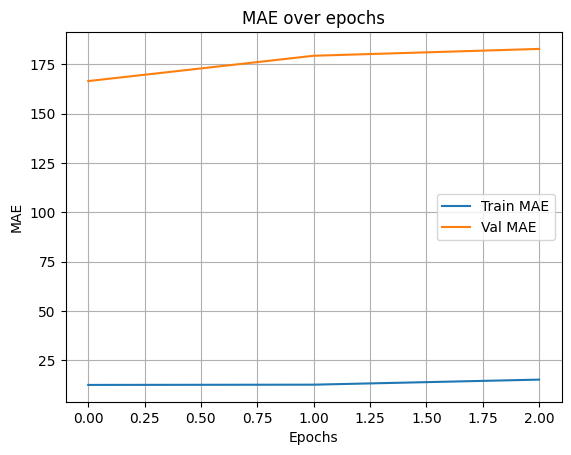

In [ ]:
loss, mae = best_model.evaluate([X_test_price, X_test_ticker], y_test)
print(f"Test MAE: {mae:.4f}")
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE over epochs")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()


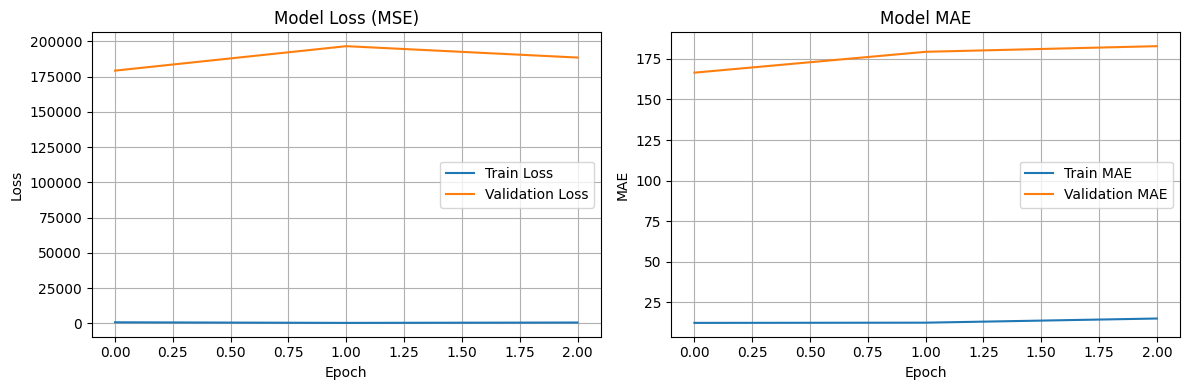

31330/31330 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step


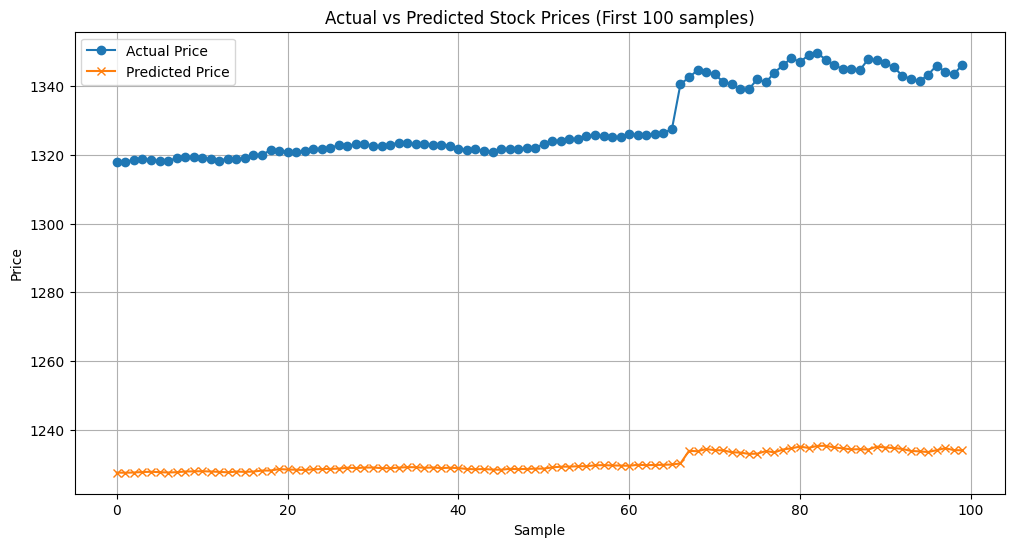

In [ ]:
# 11. Trực quan hóa kết quả

# Biểu đồ Loss và MAE
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Biểu đồ so sánh giá dự đoán và thực tế
predictions = best_model.predict([X_test_price, X_test_ticker])

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual Price', marker='o')
plt.plot(predictions[:100], label='Predicted Price', marker='x')
plt.title('Actual vs Predicted Stock Prices (First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

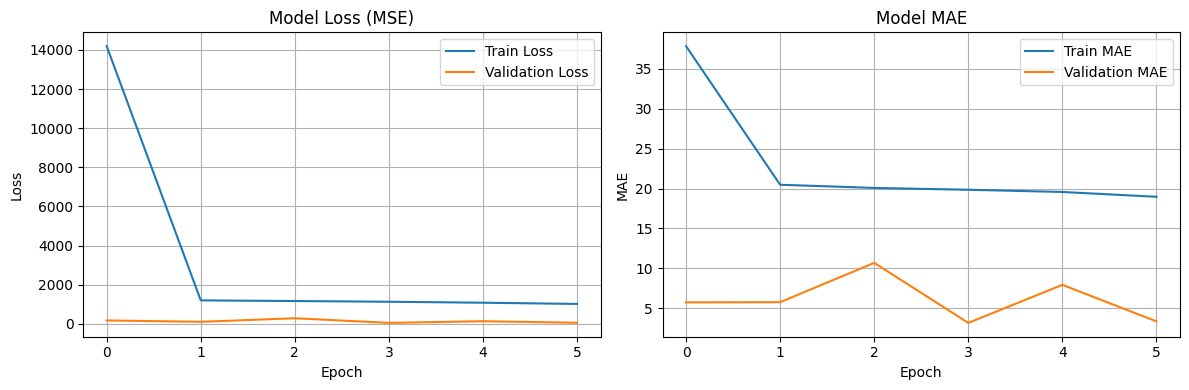

125317/125317 ━━━━━━━━━━━━━━━━━━━━ 347s 3ms/step
31330/31330 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step


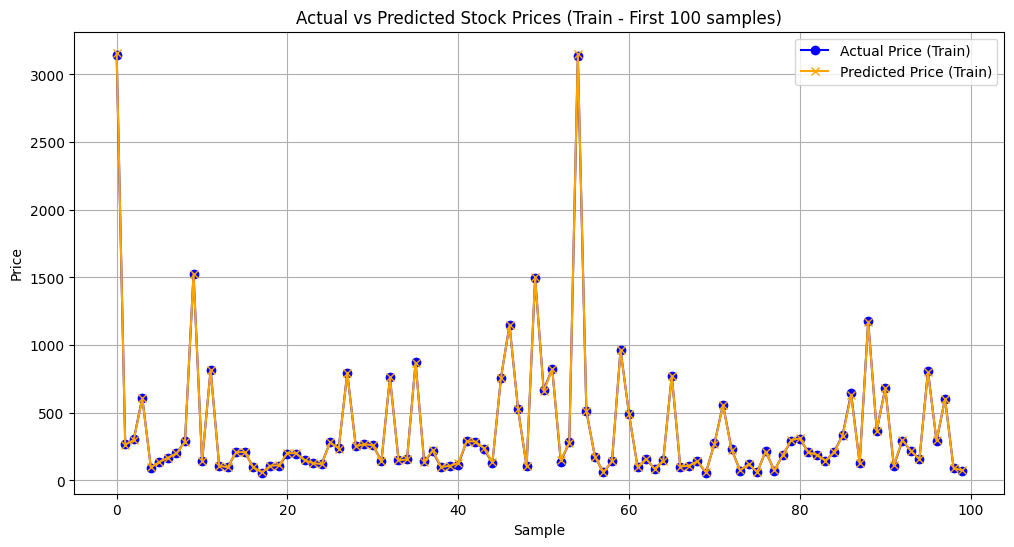

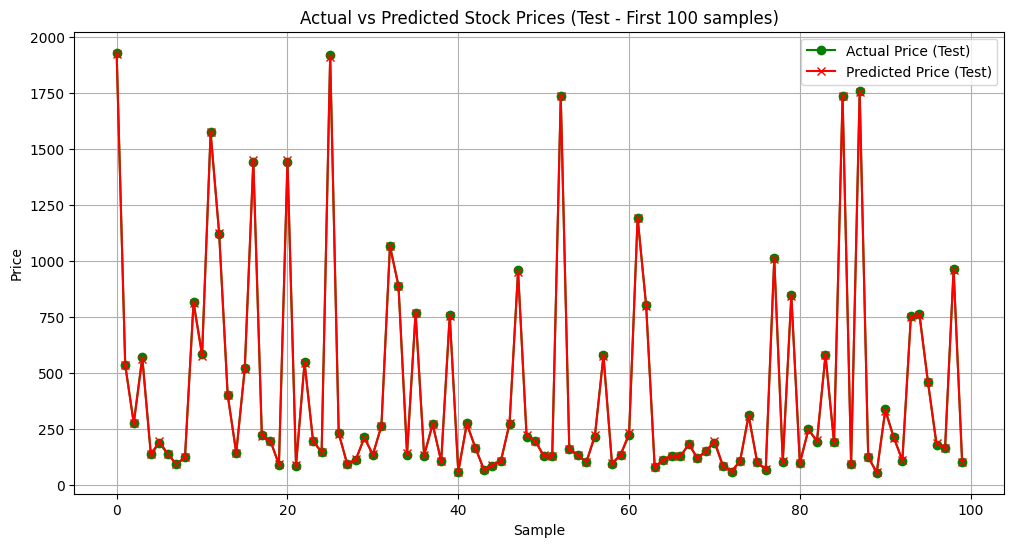

In [ ]:
# 11. Trực quan hóa kết quả

import matplotlib.pyplot as plt

# Biểu đồ Loss và MAE
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Dự đoán trên tập train và test
train_predictions = best_model.predict([X_train_price, X_train_ticker])
test_predictions = best_model.predict([X_test_price, X_test_ticker])

# Biểu đồ so sánh giá dự đoán và thực tế cho tập train
plt.figure(figsize=(12, 6))
plt.plot(y_train[:100], label='Actual Price (Train)', marker='o', color='blue')
plt.plot(train_predictions[:100], label='Predicted Price (Train)', marker='x', color='orange')
plt.title('Actual vs Predicted Stock Prices (Train - First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Biểu đồ so sánh giá dự đoán và thực tế cho tập test
plt.figure(figsize=(12, 6))
plt.plot(y_test[100:], label='Actual Price (Test)', marker='o', color='green')
plt.plot(test_predictions[:100], label='Predicted Price (Test)', marker='x', color='red')
plt.title('Actual vs Predicted Stock Prices (Test - First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# === 1. Import thư viện ===
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

# === 2. Đọc và gộp dữ liệu từ các file parquet ===
files = glob.glob('/content/drive/MyDrive/TimeSeries/Demo_Data_5/*.parquet')
dfs = []

for file in files:
    ticker = file.split('/')[-1].split('-')[0]
    df = pd.read_parquet(file)
    df['ticker'] = ticker
    df = df.reset_index().rename(columns={'index': 'datetime'})
    dfs.append(df)

merged_df = pd.concat(dfs).sort_values(by=['ticker', 'datetime']).reset_index(drop=True)

# === 3. Mã hoá ticker ===
le = LabelEncoder()
merged_df['ticker_id'] = le.fit_transform(merged_df['ticker'])
ticker_vocab_size = merged_df['ticker_id'].nunique()

# === 4. Tạo sliding window ===
def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id]
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

X, y, ticker_ids = create_sequences(merged_df, window_size=60)
X_price = X[..., np.newaxis]            # shape: (samples, 60, 1)
X_ticker = ticker_ids[:, np.newaxis]    # shape: (samples, 1)

# === 5. Chia train/test ===
X_train_price, X_test_price, X_train_ticker, X_test_ticker, y_train, y_test = train_test_split(
    X_price, X_ticker, y, test_size=0.2, random_state=42
)

# === 6. Load mô hình đã huấn luyện ===
model = load_model("best_lstm_model_vip_2.h5", compile=False)
# model = load_model("/content/drive/MyDrive/TimeSeries/test/best_lstm_model_vip.h5", compile=False)

# # === 7. Dự đoán trên tập train và test ===
# y_train_pred = model.predict([X_train_price, X_train_ticker])
# y_test_pred = model.predict([X_test_price, X_test_ticker])

# # === 8. Tạo DataFrame kết quả dự đoán ===
# train_results = pd.DataFrame({
#     'true': y_train,
#     'pred': y_train_pred.flatten(),
#     'ticker_id': X_train_ticker.flatten(),
#     'dataset': 'train'
# })

# test_results = pd.DataFrame({
#     'true': y_test,
#     'pred': y_test_pred.flatten(),
#     'ticker_id': X_test_ticker.flatten(),
#     'dataset': 'test'
# })

# # Gộp lại
# all_results = pd.concat([train_results, test_results], ignore_index=True)

# # Giải mã ticker từ ticker_id
# all_results['ticker'] = le.inverse_transform(all_results['ticker_id'])

# # === 9. Trực quan hóa kết quả theo từng mã cổ phiếu ===
# tickers = all_results['ticker'].unique()

# for ticker in tickers:
#     fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
#     fig.suptitle(f'Ticker: {ticker}', fontsize=16)

#     for i, ds in enumerate(['train', 'test']):
#         subset = all_results[(all_results['ticker'] == ticker) & (all_results['dataset'] == ds)]
#         axs[i].plot(subset['true'], label='True', color='blue')
#         axs[i].plot(subset['pred'], label='Predicted', color='orange')
#         axs[i].set_title(f'{ds.capitalize()} set')
#         axs[i].set_xlabel('Time Step')
#         axs[i].set_ylabel('Close Price')
#         axs[i].legend()

#     plt.tight_layout()
#     plt.show()

# # === 10. Tính MAE theo ticker (tuỳ chọn) ===
# mae_by_ticker = all_results.groupby(['ticker', 'dataset']).apply(
#     lambda df: np.mean(np.abs(df['true'] - df['pred']))
# ).reset_index(name='MAE')

# print("\n=== MAE theo từng ticker và tập ===")
# print(mae_by_ticker)


156646/156646 ━━━━━━━━━━━━━━━━━━━━ 427s 3ms/step


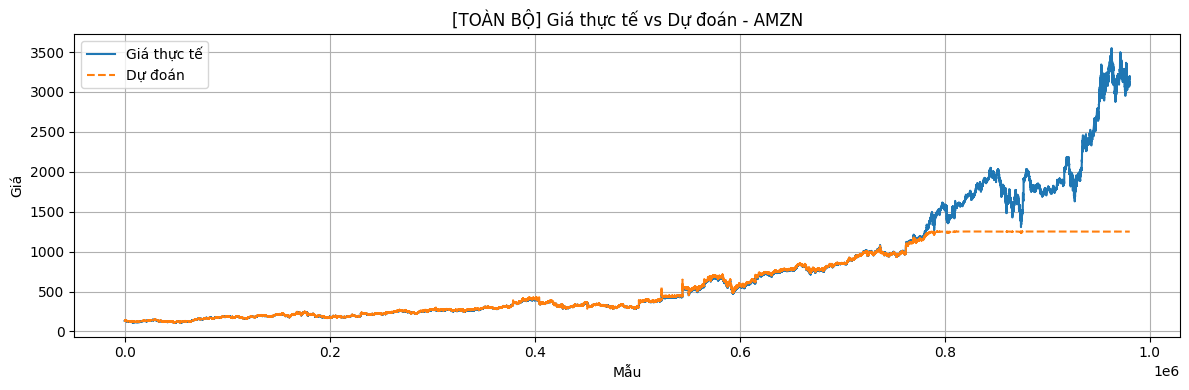

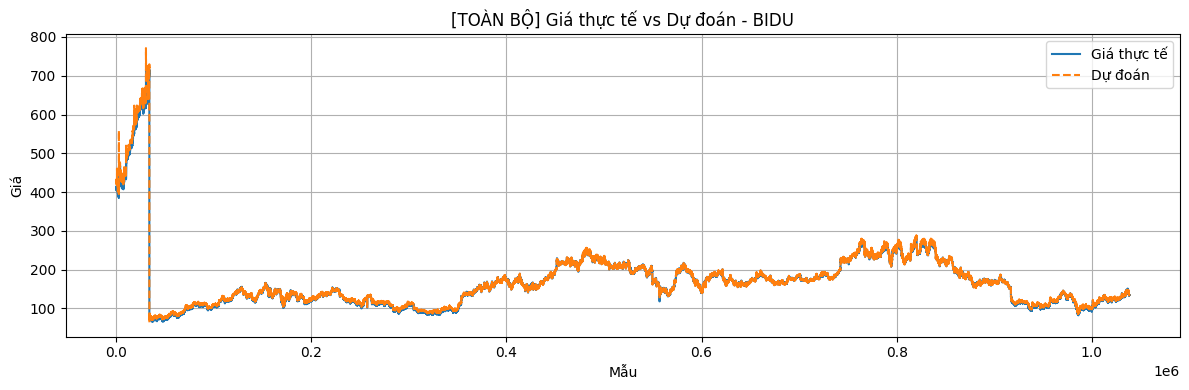

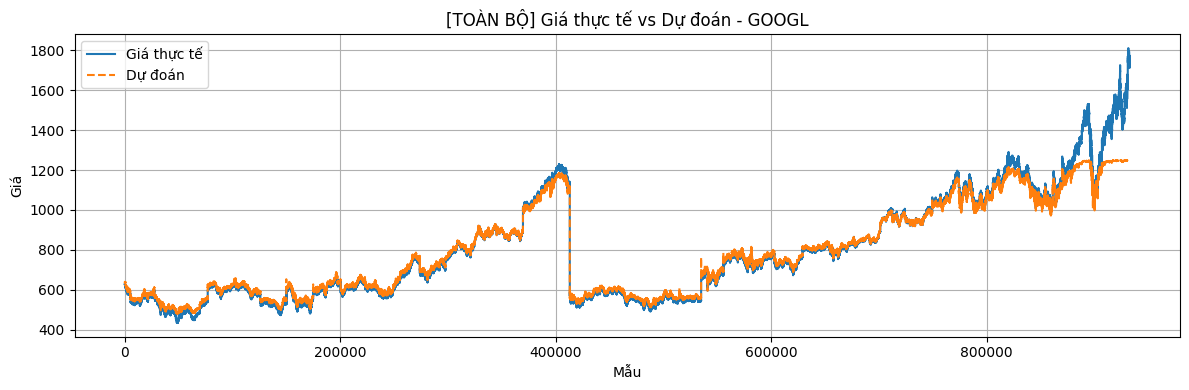

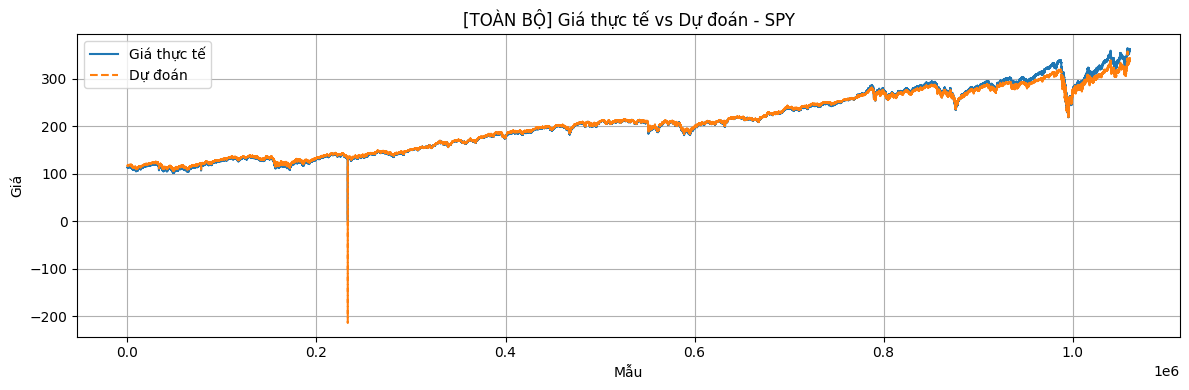

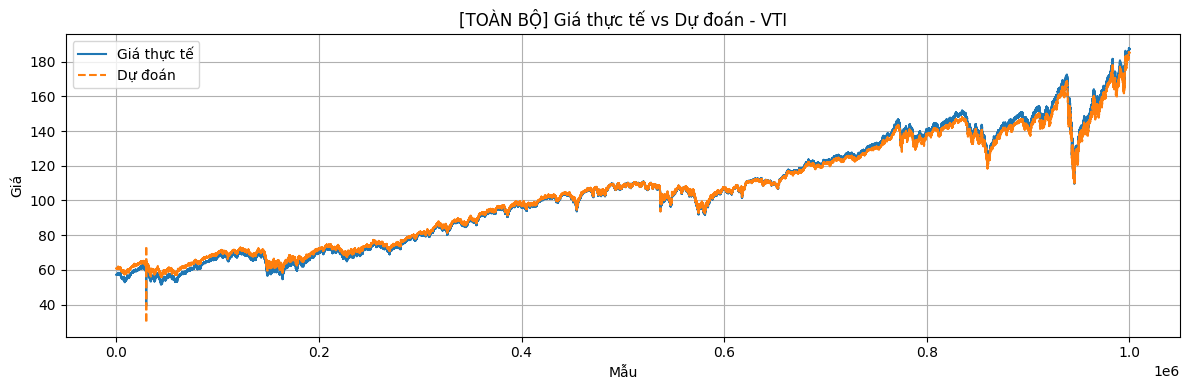

In [ ]:
# === Dự đoán toàn bộ ===
y_all_pred = model.predict([X_price, X_ticker])

# === Tạo DataFrame chứa kết quả ===
results_all_df = pd.DataFrame({
    'true': y,
    'predicted': y_all_pred.flatten(),
    'ticker_id': X_ticker.flatten()
})

# Giải mã lại ticker
results_all_df['ticker'] = le.inverse_transform(results_all_df['ticker_id'])
# Vẽ biểu đồ cho từng ticker
unique_tickers = results_all_df['ticker'].unique()

for ticker in unique_tickers:
    df_ticker = results_all_df[results_all_df['ticker'] == ticker].reset_index(drop=True)

    plt.figure(figsize=(12, 4))
    plt.plot(df_ticker.index, df_ticker['true'], label='Giá thực tế')
    plt.plot(df_ticker.index, df_ticker['predicted'], label='Dự đoán', linestyle='--')
    plt.title(f"[TOÀN BỘ] Giá thực tế vs Dự đoán - {ticker}")
    plt.xlabel("Mẫu")
    plt.ylabel("Giá")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


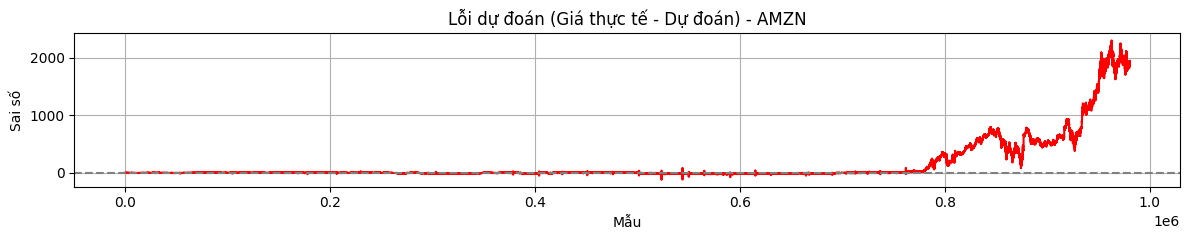

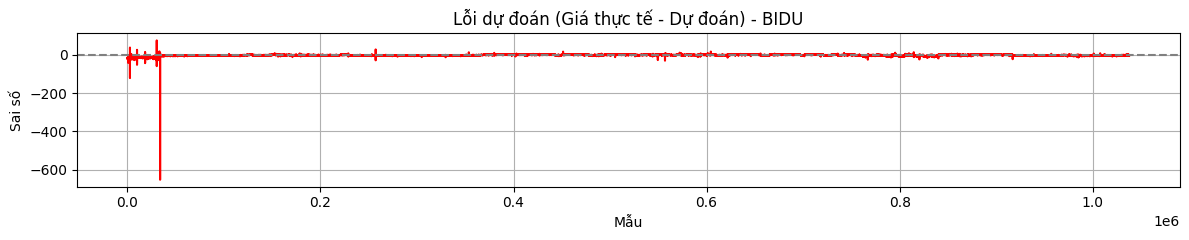

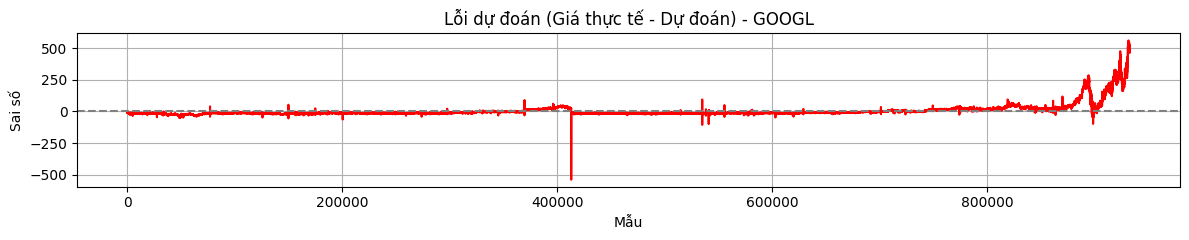

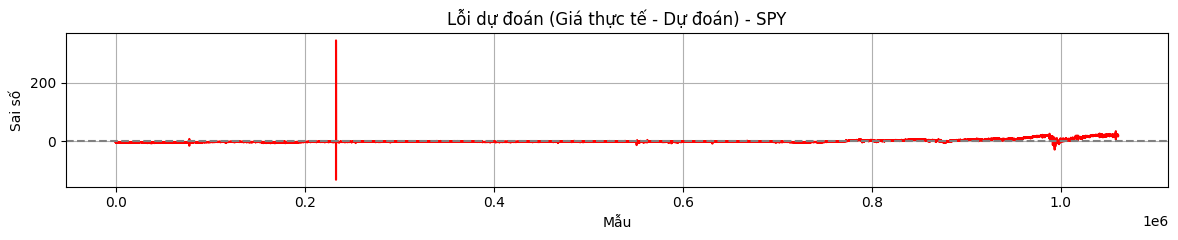

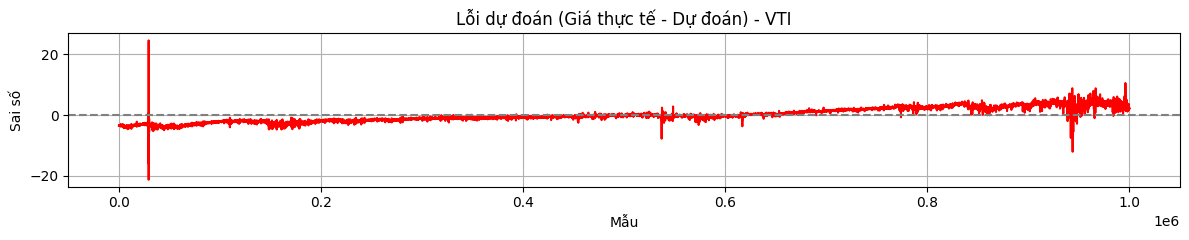

In [ ]:
results_all_df['error'] = results_all_df['true'] - results_all_df['predicted']
for ticker in unique_tickers:
    df_ticker = results_all_df[results_all_df['ticker'] == ticker].reset_index(drop=True)

    # Biểu đồ lỗi
    plt.figure(figsize=(12, 2.5))
    plt.plot(df_ticker.index, df_ticker['error'], color='red')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Lỗi dự đoán (Giá thực tế - Dự đoán) - {ticker}")
    plt.xlabel("Mẫu")
    plt.ylabel("Sai số")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Tìm tham số tốt nhất bằng Keras tuner

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
# 0. Import thư viện
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# 1. Hàm tiền xử lý dữ liệu parquet minute stock
def preprocess_stock_minute_data_fast(parquet_folder_path, missing_threshold=0.8):
    print("Step 1: Đọc các file parquet trong thư mục...")
    files = glob.glob(f"{parquet_folder_path}/*.parquet")
    print(f"  Tìm thấy {len(files)} file parquet.")

    dfs = []
    for file in files:
        ticker = file.split("/")[-1].split("-")[0]
        print(f"  Đang đọc file cho ticker: {ticker}")
        df = pd.read_parquet(file)
        df["ticker"] = ticker
        df = df.reset_index().rename(columns={"index": "datetime"})
        dfs.append(df)

    print("Step 2: Gộp dữ liệu từ các file lại và sắp xếp...")
    merged_df = pd.concat(dfs).sort_values(by=["ticker", "datetime"]).reset_index(drop=True)
    merged_df["datetime"] = pd.to_datetime(merged_df["datetime"])
    merged_df["date"] = merged_df["datetime"].dt.date
    print(f"  Tổng số dòng sau gộp: {len(merged_df)}")
    print(f"  Khoảng thời gian: {merged_df['datetime'].min()} đến {merged_df['datetime'].max()}")

    print("Step 3: Mã hóa ticker...")
    le = LabelEncoder()
    merged_df["ticker_id"] = le.fit_transform(merged_df["ticker"])
    print(f"  Số lượng ticker khác nhau: {merged_df['ticker_id'].nunique()}")

    result = []
    grouped = merged_df.groupby(["ticker", "date"])
    print("Step 4: Xử lý theo từng ticker từng ngày...")
    for i, ((ticker, date), group) in enumerate(grouped):
        if i % 50 == 0:
            print(f"  Đang xử lý ticker {ticker}, ngày {date}... ({i+1}/{len(grouped)})")

        group = group.set_index("datetime")
        group = group[~group.index.duplicated(keep="first")]

        # Tạo index đầy đủ 1 phút trong khoảng 17:30 - 23:59
        full_index = pd.date_range(f"{date} 17:30", f"{date} 23:59", freq="1min")
        group = group.reindex(full_index)

        missing_ratio = group["close"].isna().mean()
        if missing_ratio > missing_threshold:
            # Bỏ ngày này nếu thiếu quá nhiều dữ liệu
            continue

        # Điền NaN bằng ffill rồi bfill
        group[["open", "high", "low", "close", "vol"]] = group[["open", "high", "low", "close", "vol"]].ffill()
        group[["open", "high", "low", "close", "vol"]] = group[["open", "high", "low", "close", "vol"]].bfill()

        group["ticker"] = ticker
        group["ticker_id"] = le.transform([ticker])[0]
        group["date"] = date

        result.append(group)

    print("Step 5: Ghép các nhóm lại thành dataframe cuối cùng...")
    final_df = pd.concat(result).reset_index().rename(columns={"index": "datetime"})

    print(f"Hoàn thành tiền xử lý, tổng dòng sau xử lý: {len(final_df)}")
    return final_df, le

# 2. Tiền xử lý, đọc dữ liệu
parquet_path = '/content/drive/MyDrive/TimeSeries/Demo_Data_5'
final_df, label_encoder = preprocess_stock_minute_data_fast(parquet_path)

print("\nThông tin chung sau xử lý:")
print(" - Số dòng dữ liệu:", len(final_df))
print(" - Các ticker có trong dữ liệu:", final_df['ticker'].unique())
print(" - Khoảng thời gian dữ liệu:", final_df['datetime'].min(), "->", final_df['datetime'].max())

# 3. Hàm tạo sequences sliding window
def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id]
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

X, y, ticker_ids = create_sequences(final_df, window_size=60)
X_price = X[..., np.newaxis]          # shape (samples, 60, 1)
X_ticker = ticker_ids[:, np.newaxis] # shape (samples, 1)

# 4. Hàm tách train/test theo từng ticker giữ thứ tự thời gian
def split_by_time_per_ticker(X_price, y, X_ticker, test_ratio=0.2):
    X_train_price, X_test_price = [], []
    X_train_ticker, X_test_ticker = [], []
    y_train, y_test = [], []

    unique_tickers = np.unique(X_ticker)

    for ticker_id in unique_tickers:
        idx = np.where(X_ticker.flatten() == ticker_id)[0]

        # Giữ nguyên thứ tự thời gian
        ticker_X_price = X_price[idx]
        ticker_y = y[idx]
        ticker_X_ticker = X_ticker[idx]

        split_idx = int(len(idx) * (1 - test_ratio))

        X_train_price.append(ticker_X_price[:split_idx])
        X_test_price.append(ticker_X_price[split_idx:])
        y_train.append(ticker_y[:split_idx])
        y_test.append(ticker_y[split_idx:])
        X_train_ticker.append(ticker_X_ticker[:split_idx])
        X_test_ticker.append(ticker_X_ticker[split_idx:])

    return (
        np.concatenate(X_train_price),
        np.concatenate(X_test_price),
        np.concatenate(X_train_ticker),
        np.concatenate(X_test_ticker),
        np.concatenate(y_train),
        np.concatenate(y_test)
    )

X_train_price, X_test_price, X_train_ticker, X_test_ticker, y_train, y_test = split_by_time_per_ticker(
    X_price, y, X_ticker, test_ratio=0.2
)

# 5. Lấy vocab size của ticker từ label_encoder
ticker_vocab_size = len(label_encoder.classes_)

# 6. Định nghĩa mô hình với Keras Tuner
def build_model(hp):
    time_steps = X_train_price.shape[1]

    embedding_dim = hp.Int("embedding_dim", 4, 32, step=4)
    lstm_units = hp.Int("lstm_units", 32, 128, step=16)
    dense_units = hp.Int("dense_units", 32, 128, step=16)
    dropout_rate = hp.Float("dropout", 0.1, 0.5, step=0.1)
    learning_rate = hp.Choice("lr", [1e-2, 1e-3, 1e-4])

    price_input = Input(shape=(time_steps, 1), name="price_input")
    ticker_input = Input(shape=(1,), name="ticker_input")

    ticker_embedding = Embedding(input_dim=ticker_vocab_size, output_dim=embedding_dim)(ticker_input)
    ticker_embedding_flat = Flatten()(ticker_embedding)

    x = LSTM(units=lstm_units)(price_input)
    x = Dropout(dropout_rate)(x)

    x = Concatenate()([x, ticker_embedding_flat])
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=[price_input, ticker_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mse', metrics=['mae'])
    return model



Step 1: Đọc các file parquet trong thư mục...
  Tìm thấy 5 file parquet.
  Đang đọc file cho ticker: AMZN
  Đang đọc file cho ticker: BIDU
  Đang đọc file cho ticker: GOOGL
  Đang đọc file cho ticker: SPY
  Đang đọc file cho ticker: VTI
Step 2: Gộp dữ liệu từ các file lại và sắp xếp...
  Tổng số dòng sau gộp: 5012961
  Khoảng thời gian: 2010-01-01 00:00:00 đến 2020-11-25 23:59:00
Step 3: Mã hóa ticker...
  Số lượng ticker khác nhau: 5
Step 4: Xử lý theo từng ticker từng ngày...
  Đang xử lý ticker AMZN, ngày 2010-01-04... (1/14701)
  Đang xử lý ticker AMZN, ngày 2010-03-17... (51/14701)
  Đang xử lý ticker AMZN, ngày 2010-05-27... (101/14701)
  Đang xử lý ticker AMZN, ngày 2010-08-09... (151/14701)
  Đang xử lý ticker AMZN, ngày 2010-10-19... (201/14701)
  Đang xử lý ticker AMZN, ngày 2010-12-30... (251/14701)
  Đang xử lý ticker AMZN, ngày 2011-03-14... (301/14701)
  Đang xử lý ticker AMZN, ngày 2011-05-24... (351/14701)
  Đang xử lý ticker AMZN, ngày 2011-08-04... (401/14701)
  Đang 

In [ ]:
# 7. Tuner tìm kiếm hyperparameter tốt nhất
tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=3,
    executions_per_trial=1,
    directory="lstm_dic",
    project_name="stock_forecast"
)

tuner.search(
    [X_train_price, X_train_ticker],
    y_train,
    validation_data=([X_test_price, X_test_ticker], y_test),
    epochs=3,
    batch_size=64
)



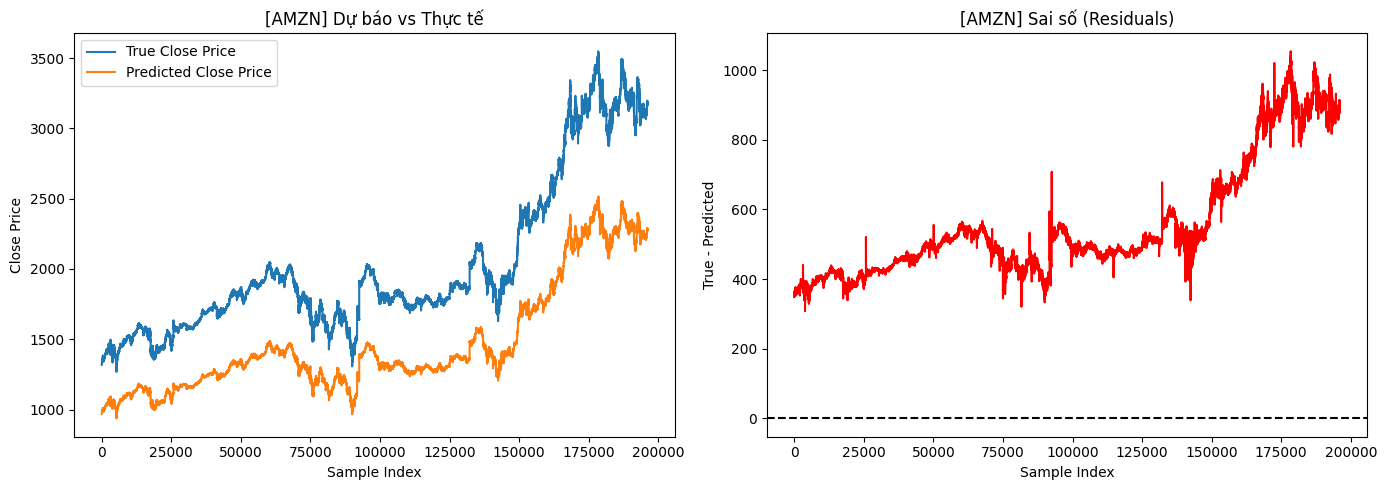

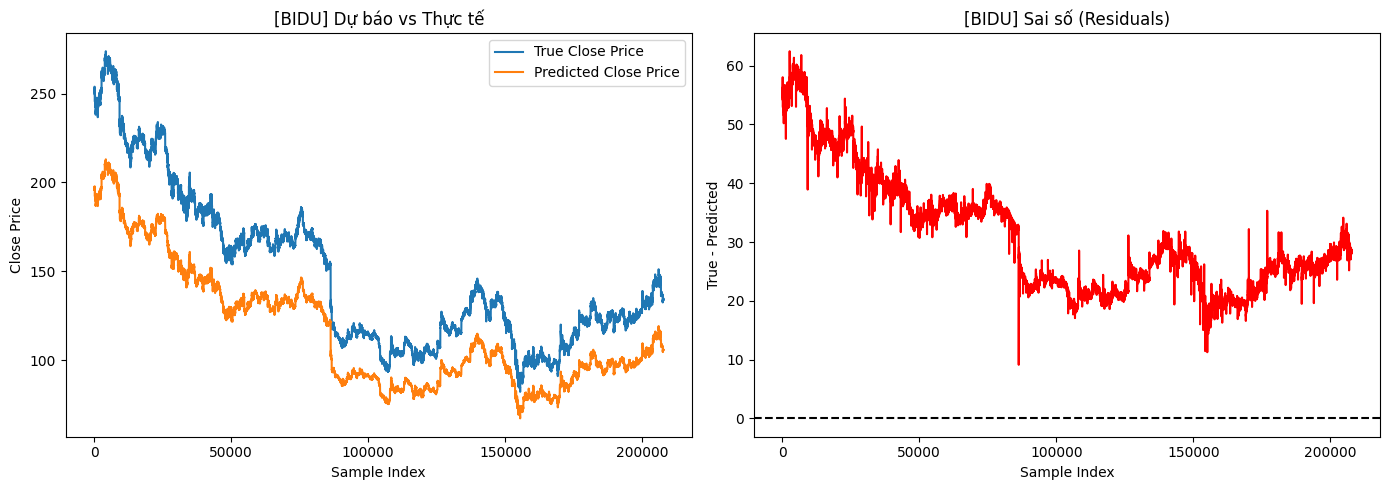

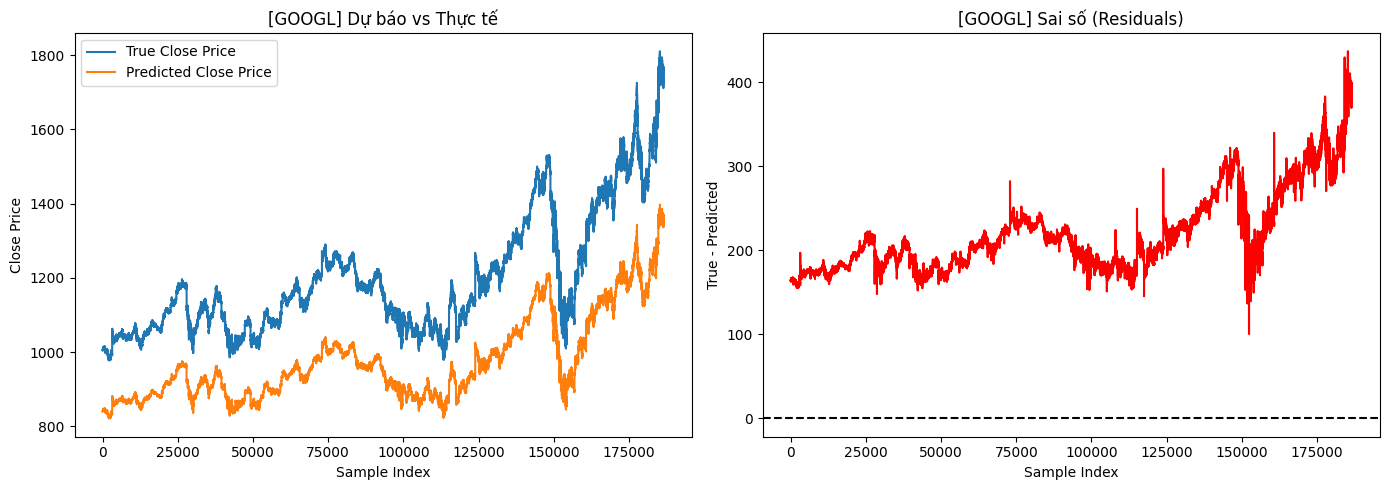

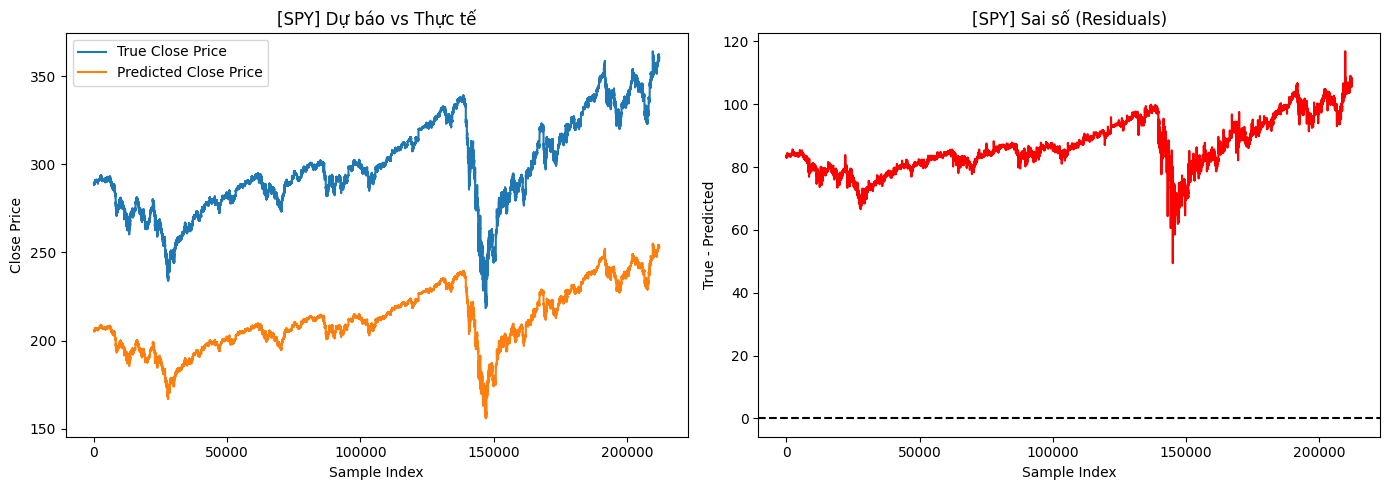

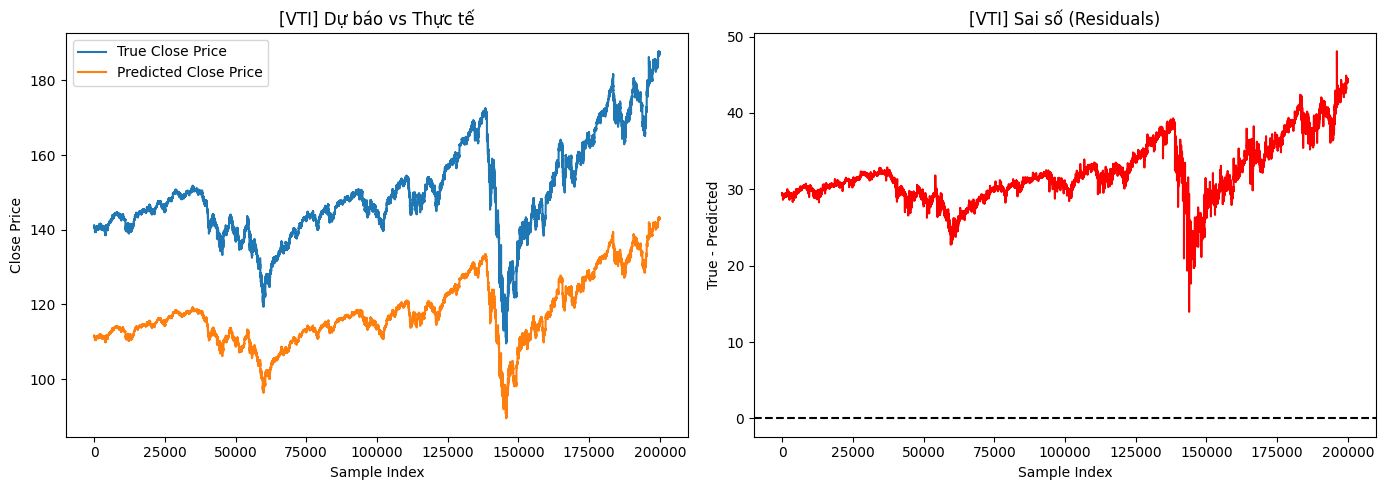

In [ ]:
# 1. Import thư viện
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# 2. Hàm tiền xử lý (chuẩn hóa theo từng ticker)
def preprocess_and_scale(parquet_folder_path, missing_threshold=0.8):
    files = glob.glob(f"{parquet_folder_path}/*.parquet")
    dfs = []

    for file in files:
        ticker = file.split("/")[-1].split("-")[0]
        df = pd.read_parquet(file)
        df["ticker"] = ticker
        df = df.reset_index().rename(columns={"index": "datetime"})
        dfs.append(df)

    merged_df = pd.concat(dfs).sort_values(by=["ticker", "datetime"]).reset_index(drop=True)
    merged_df["datetime"] = pd.to_datetime(merged_df["datetime"])

    le = LabelEncoder()
    merged_df["ticker_id"] = le.fit_transform(merged_df["ticker"])

    # Chuẩn hóa theo từng ticker
    final = []
    scalers = {}
    for ticker in merged_df["ticker"].unique():
        df_ticker = merged_df[merged_df["ticker"] == ticker].copy()
        df_ticker = df_ticker.set_index("datetime").sort_index()
        df_ticker = df_ticker[~df_ticker.index.duplicated(keep="first")]

        if df_ticker["close"].isna().mean() > missing_threshold:
            continue

        df_ticker["close"] = df_ticker["close"].ffill().bfill()
        scaler = MinMaxScaler()
        df_ticker["close"] = scaler.fit_transform(df_ticker[["close"]])
        scalers[ticker] = scaler

        df_ticker = df_ticker.reset_index()
        final.append(df_ticker)

    final_df = pd.concat(final).sort_values(["ticker", "datetime"]).reset_index(drop=True)
    return final_df, le, scalers

# 3. Tạo sliding window
def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id].sort_values("datetime")
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

# 4. Chia train/val/test theo từng ticker
def split_timewise(X_price, y, X_ticker, test_ratio=0.2, val_ratio=0.2):
    X_train_p, X_val_p, X_test_p = [], [], []
    X_train_t, X_val_t, X_test_t = [], [], []
    y_train, y_val, y_test = [], [], []

    for tid in np.unique(X_ticker):
        idx = np.where(X_ticker.flatten() == tid)[0]
        n = len(idx)
        if n < 10:
            continue
        n_test = int(n * test_ratio)
        n_val = int((n - n_test) * val_ratio)

        X_tkr = X_price[idx]
        y_tkr = y[idx]
        T_tkr = X_ticker[idx]

        X_train_p.append(X_tkr[:-n_test - n_val])
        y_train.append(y_tkr[:-n_test - n_val])
        X_train_t.append(T_tkr[:-n_test - n_val])

        X_val_p.append(X_tkr[-n_test - n_val:-n_test])
        y_val.append(y_tkr[-n_test - n_val:-n_test])
        X_val_t.append(T_tkr[-n_test - n_val:-n_test])

        X_test_p.append(X_tkr[-n_test:])
        y_test.append(y_tkr[-n_test:])
        X_test_t.append(T_tkr[-n_test:])

    return map(np.concatenate, [X_train_p, X_val_p, X_test_p,
                                X_train_t, X_val_t, X_test_t,
                                y_train, y_val, y_test])

# 5. Load dữ liệu và tạo dữ liệu dự đoán
parquet_path = '/content/drive/MyDrive/TimeSeries/Demo_Data_5'  # Cập nhật đường dẫn
merged_df, label_encoder, scalers = preprocess_and_scale(parquet_path)
X, y, ticker_ids = create_sequences(merged_df, window_size=60)
X_price = X[..., np.newaxis]
X_ticker = ticker_ids[:, np.newaxis]

X_train_price, X_val_price, X_test_price, \
X_train_ticker, X_val_ticker, X_test_ticker, \
y_train, y_val, y_test = split_timewise(X_price, y, X_ticker)

# 6. Load mô hình đã huấn luyện
model = load_model("stock_lstm_ticker.h5", compile=False)

# 7. Dự đoán trên từng ticker trong tập test
unique_tickers = np.unique(X_test_ticker)

for tid in unique_tickers:
    idx = np.where(X_test_ticker.flatten() == tid)[0]
    ticker_name = label_encoder.inverse_transform([tid])[0]
    scaler = scalers[ticker_name]

    y_true = y_test[idx]
    y_pred_ticker = model.predict({
        "price_input": X_test_price[idx],
        "ticker_input": X_test_ticker[idx]
    }, verbose=0)

    # Đảo chuẩn hóa
    y_true_rescaled = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_rescaled = scaler.inverse_transform(y_pred_ticker).flatten()
    residuals = y_true_rescaled - y_pred_rescaled

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 5))

    # Dự báo vs Thực tế
    plt.subplot(1, 2, 1)
    plt.plot(y_true_rescaled, label="True Close Price")
    plt.plot(y_pred_rescaled, label="Predicted Close Price")
    plt.title(f"[{ticker_name}] Dự báo vs Thực tế")
    plt.xlabel("Sample Index")
    plt.ylabel("Close Price")
    plt.legend()

    # Biểu đồ Sai số
    plt.subplot(1, 2, 2)
    plt.plot(residuals, color='red')
    plt.axhline(0, linestyle='--', color='black')
    plt.title(f"[{ticker_name}] Sai số (Residuals)")
    plt.xlabel("Sample Index")
    plt.ylabel("True - Predicted")

    plt.tight_layout()
    plt.show()


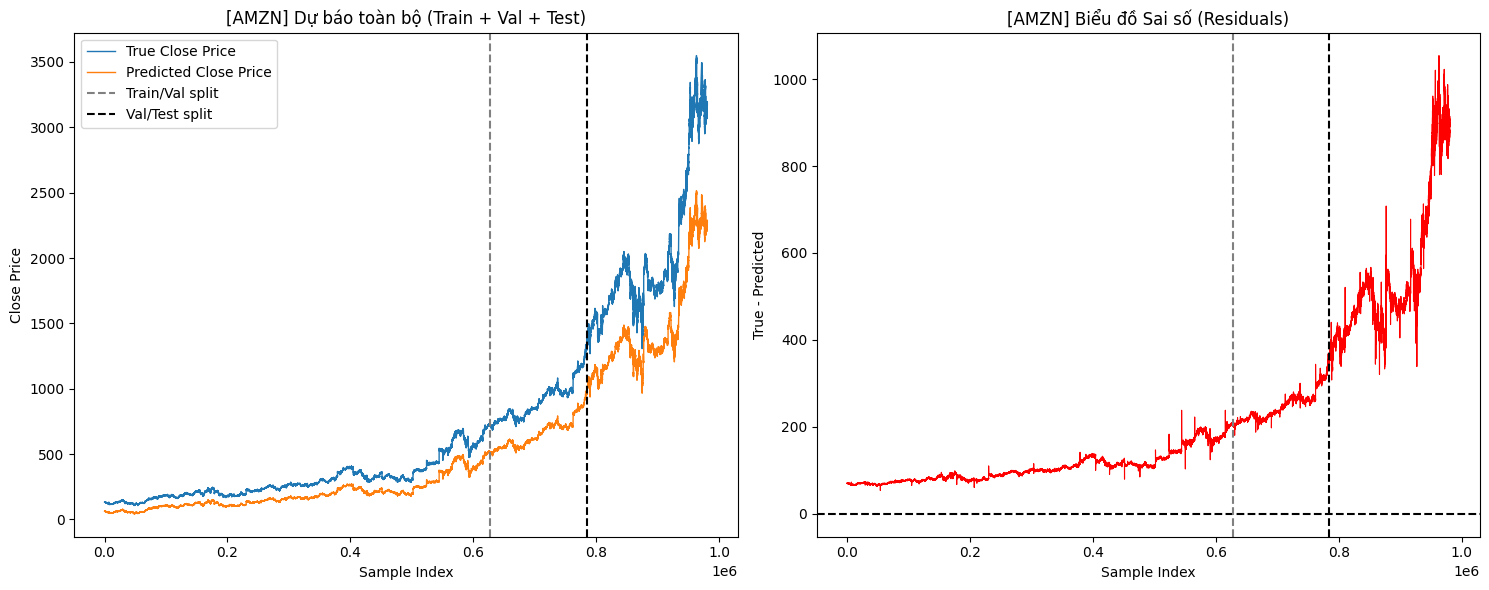

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


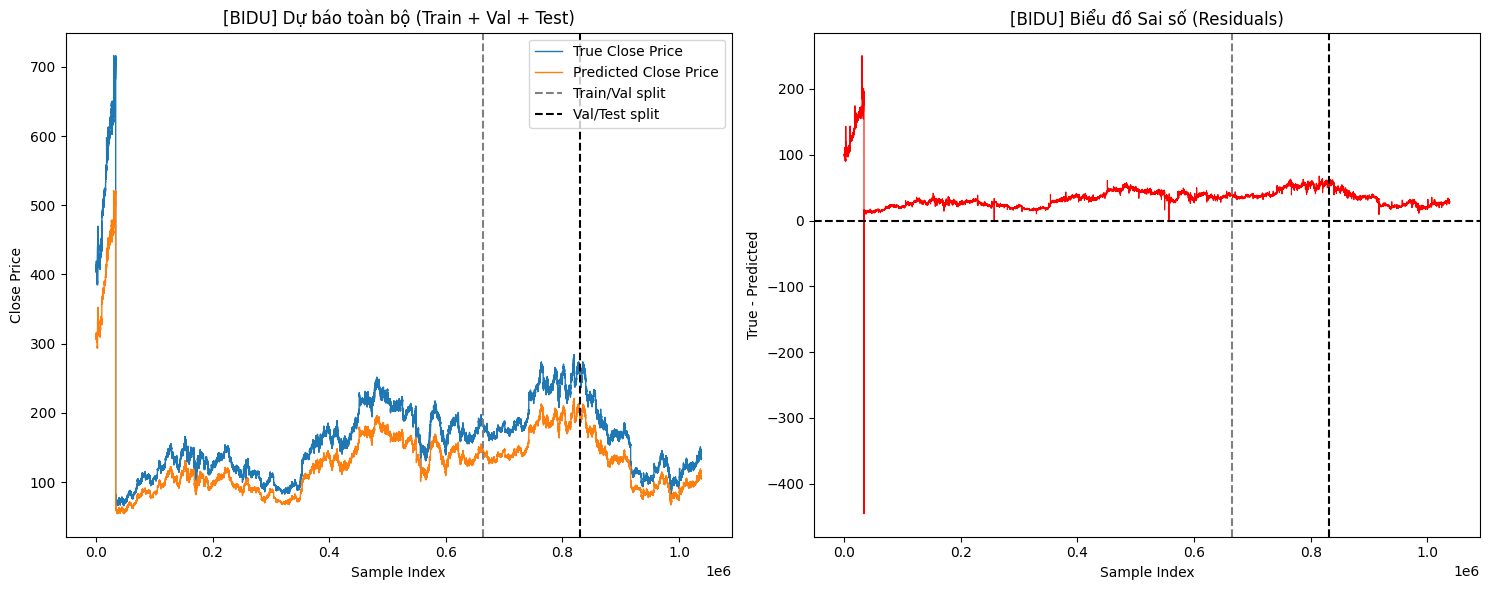

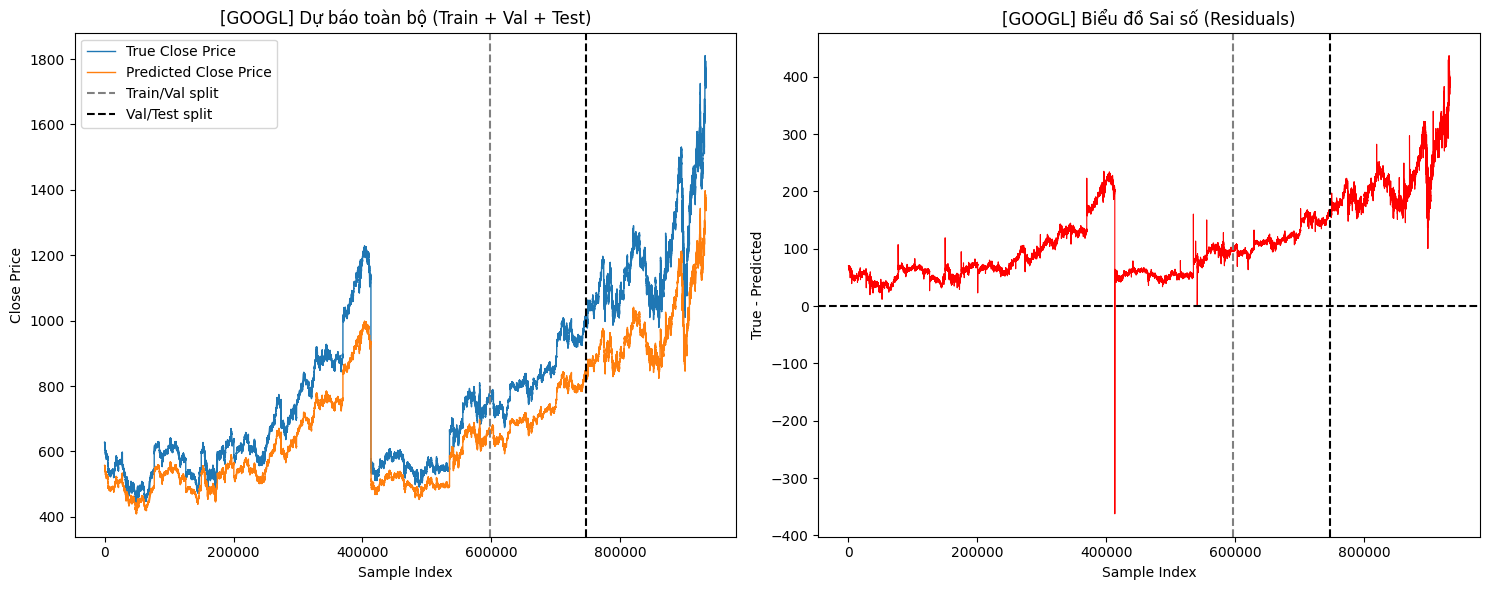

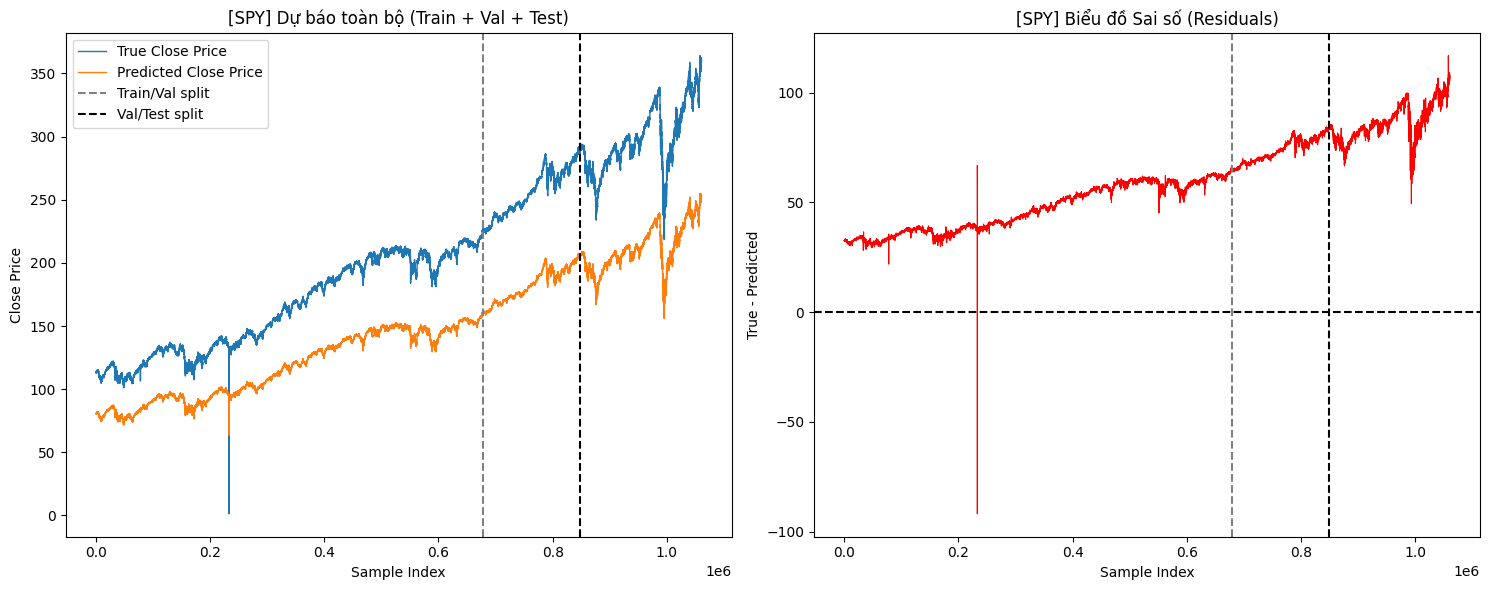

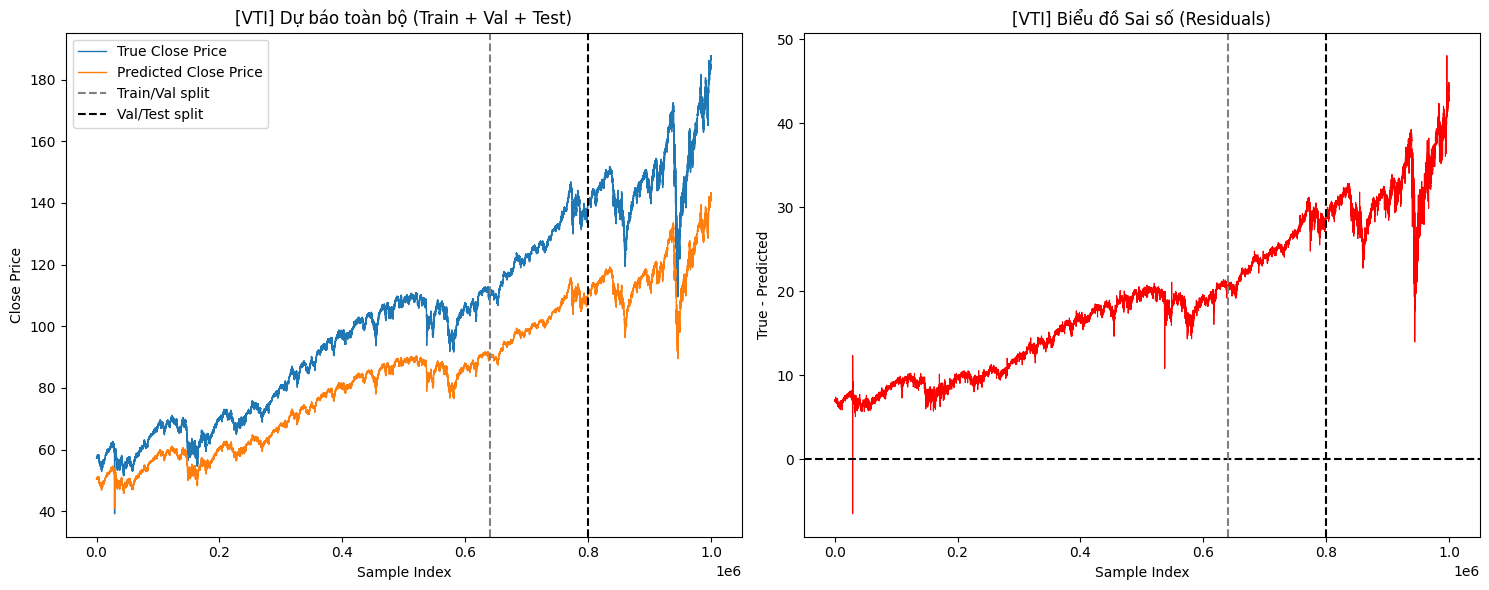

In [ ]:
for tid in np.unique(X_test_ticker):  # test có đầy đủ các ticker hợp lệ
    ticker_name = label_encoder.inverse_transform([tid])[0]
    scaler = scalers[ticker_name]

    # Lấy toàn bộ chỉ mục của ticker này ở mỗi tập
    idx_train = np.where(X_train_ticker.flatten() == tid)[0]
    idx_val = np.where(X_val_ticker.flatten() == tid)[0]
    idx_test = np.where(X_test_ticker.flatten() == tid)[0]

    if len(idx_train) == 0 or len(idx_test) == 0:
        continue  # bỏ qua nếu thiếu dữ liệu

    # Dự đoán
    y_pred_train = model.predict({
        "price_input": X_train_price[idx_train],
        "ticker_input": X_train_ticker[idx_train]
    }, verbose=0)
    y_pred_val = model.predict({
        "price_input": X_val_price[idx_val],
        "ticker_input": X_val_ticker[idx_val]
    }, verbose=0)
    y_pred_test = model.predict({
        "price_input": X_test_price[idx_test],
        "ticker_input": X_test_ticker[idx_test]
    }, verbose=0)

    # Ghép lại
    y_true_all = np.concatenate([y_train[idx_train], y_val[idx_val], y_test[idx_test]])
    y_pred_all = np.concatenate([y_pred_train, y_pred_val, y_pred_test])

    # Đảo chuẩn hóa
    y_true_rescaled = scaler.inverse_transform(y_true_all.reshape(-1, 1)).flatten()
    y_pred_rescaled = scaler.inverse_transform(y_pred_all).flatten()
    residuals = y_true_rescaled - y_pred_rescaled

    # Xác định index split cho biểu đồ
    train_len = len(idx_train)
    val_len = len(idx_val)

    # Vẽ biểu đồ
    plt.figure(figsize=(15, 6))

    # 1. Biểu đồ Dự báo vs Thực tế
    plt.subplot(1, 2, 1)
    plt.plot(y_true_rescaled, label="True Close Price", linewidth=1)
    plt.plot(y_pred_rescaled, label="Predicted Close Price", linewidth=1)

    plt.axvline(train_len, color='gray', linestyle='--', label='Train/Val split')
    plt.axvline(train_len + val_len, color='black', linestyle='--', label='Val/Test split')

    plt.title(f"[{ticker_name}] Dự báo toàn bộ (Train + Val + Test)")
    plt.xlabel("Sample Index")
    plt.ylabel("Close Price")
    plt.legend()

    # 2. Biểu đồ Sai số
    plt.subplot(1, 2, 2)
    plt.plot(residuals, color='red', linewidth=0.8)
    plt.axhline(0, linestyle='--', color='black')
    plt.axvline(train_len, color='gray', linestyle='--')
    plt.axvline(train_len + val_len, color='black', linestyle='--')
    plt.title(f"[{ticker_name}] Biểu đồ Sai số (Residuals)")
    plt.xlabel("Sample Index")
    plt.ylabel("True - Predicted")

    plt.tight_layout()
    plt.show()


# Huấn luyện mô hình ban đầu

In [ ]:
import pandas as pd
import numpy as np
import glob
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# --- Bước 1: Khởi tạo và lưu LabelEncoder từ toàn bộ dữ liệu ---

def fit_label_encoder_on_all_tickers(parquet_folder_path, save_path="label_encoder.pkl"):
    files = glob.glob(f"{parquet_folder_path}/*.parquet")
    tickers = []
    for file in files:
        ticker = file.split("/")[-1].split("-")[0]
        tickers.append(ticker)
    tickers = sorted(set(tickers))
    le = LabelEncoder()
    le.fit(tickers)
    with open(save_path, "wb") as f:
        pickle.dump(le, f)
    print(f"LabelEncoder fitted and saved with {len(tickers)} tickers.")
    return le

# --- Bước 2: Hàm tiền xử lý dữ liệu từng batch, dùng label_encoder đã có ---

def preprocess_and_scale_batch(parquet_folder_path, label_encoder, missing_threshold=0.8):
    files = glob.glob(f"{parquet_folder_path}/*.parquet")
    dfs = []

    for file in files:
        ticker = file.split("/")[-1].split("-")[0]
        if ticker not in label_encoder.classes_:
            print(f"Warning: Ticker {ticker} not in label encoder classes, skip.")
            continue
        df = pd.read_parquet(file)
        df["ticker"] = ticker
        df = df.reset_index().rename(columns={"index": "datetime"})
        dfs.append(df)

    merged_df = pd.concat(dfs).sort_values(by=["ticker", "datetime"]).reset_index(drop=True)
    merged_df["datetime"] = pd.to_datetime(merged_df["datetime"])
    merged_df["date"] = merged_df["datetime"].dt.date

    merged_df["ticker_id"] = label_encoder.transform(merged_df["ticker"])

    final = []
    scalers = {}

    grouped = merged_df.groupby(["ticker", "date"])
    for (ticker, date), group in grouped:
        group = group.set_index("datetime").sort_index()
        group = group[~group.index.duplicated(keep="first")]

        # Tạo time index chuẩn cho khung giờ 17:30 - 23:59
        full_index = pd.date_range(f"{date} 17:30", f"{date} 23:59", freq="1min")
        group = group.reindex(full_index)

        missing_ratio = group["close"].isna().mean()
        if missing_ratio > missing_threshold:
            print("Xử lý")
            continue

        group["close"] = group["close"].ffill().bfill()
        group["ticker"] = ticker
        group["ticker_id"] = label_encoder.transform([ticker])[0]
        group["date"] = date

        final.append(group.reset_index().rename(columns={"index": "datetime"}))

    final_df = pd.concat(final).sort_values(["ticker", "datetime"]).reset_index(drop=True)

    # Chuẩn hóa theo từng ticker
    final_df["scaled_close"] = 0.0
    for ticker in final_df["ticker"].unique():
        mask = final_df["ticker"] == ticker
        scaler = StandardScaler()
        final_df.loc[mask, "scaled_close"] = scaler.fit_transform(final_df.loc[mask, ["close"]])
        scalers[ticker] = scaler

    final_df["close"] = final_df["scaled_close"]
    final_df = final_df.drop(columns=["scaled_close"])

    return final_df, scalers


# --- Bước 3: Tạo sequence, chia dữ liệu, ... như trước ---

def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id].sort_values("datetime")
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

def split_timewise(X_price, y, X_ticker, test_ratio=0.2, val_ratio=0.2):
    X_train_p, X_val_p, X_test_p = [], [], []
    X_train_t, X_val_t, X_test_t = [], [], []
    y_train, y_val, y_test = [], [], []

    for tid in np.unique(X_ticker):
        idx = np.where(X_ticker.flatten() == tid)[0]
        n = len(idx)
        if n < 10:
            continue
        n_test = int(n * test_ratio)
        n_val = int((n - n_test) * val_ratio)

        X_tkr = X_price[idx]
        y_tkr = y[idx]
        T_tkr = X_ticker[idx]

        X_train_p.append(X_tkr[:-n_test - n_val])
        y_train.append(y_tkr[:-n_test - n_val])
        X_train_t.append(T_tkr[:-n_test - n_val])

        X_val_p.append(X_tkr[-n_test - n_val:-n_test])
        y_val.append(y_tkr[-n_test - n_val:-n_test])
        X_val_t.append(T_tkr[-n_test - n_val:-n_test])

        X_test_p.append(X_tkr[-n_test:])
        y_test.append(y_tkr[-n_test:])
        X_test_t.append(T_tkr[-n_test:])

    return map(np.concatenate, [X_train_p, X_val_p, X_test_p,
                                X_train_t, X_val_t, X_test_t,
                                y_train, y_val, y_test])

# --- Bước 4: Xây dựng model ---

def build_model(ticker_vocab_size, time_steps):
    embedding_dim = 8
    lstm_units = 64
    dense_units = 80
    dropout_rate = 0.2

    price_input = Input(shape=(time_steps, 1), name="price_input")
    ticker_input = Input(shape=(1,), name="ticker_input")

    ticker_embedding = Embedding(input_dim=ticker_vocab_size, output_dim=embedding_dim)(ticker_input)
    ticker_embedding_flat = Flatten()(ticker_embedding)

    x = LSTM(lstm_units, return_sequences=True)(price_input)
    x = LSTM(lstm_units)(x)
    x = Dropout(dropout_rate)(x)

    x = Concatenate()([x, ticker_embedding_flat])
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=[price_input, ticker_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.Huber(),
        metrics=['mae', tf.keras.metrics.MeanAbsolutePercentageError()]
    )
    return model

# --- Ví dụ sử dụng ---

# Khởi tạo label encoder 1 lần duy nhất (chỉ cần chạy 1 lần)
label_encoder_path = "label_encoder.pkl"
parquet_folder_all = "/content/drive/MyDrive/TimeSeries/Data"  # folder chứa tất cả data gốc
label_encoder = fit_label_encoder_on_all_tickers(parquet_folder_all, save_path=label_encoder_path)

# Load lại khi train từng batch (ví dụ một folder nhỏ)
with open(label_encoder_path, "rb") as f:
    label_encoder = pickle.load(f)

parquet_batch_folder = "/content/drive/MyDrive/TimeSeries/Demo_Data_5"
df_batch, scalers_batch = preprocess_and_scale_batch(parquet_batch_folder, label_encoder)

X, y, ticker_ids = create_sequences(df_batch, window_size=60)
X_price = X[..., np.newaxis]
X_ticker = ticker_ids[:, np.newaxis]

X_train_price, X_val_price, X_test_price, \
X_train_ticker, X_val_ticker, X_test_ticker, \
y_train, y_val, y_test = split_timewise(X_price, y, X_ticker)

ticker_vocab_size = len(label_encoder.classes_)
time_steps = X_train_price.shape[1]



LabelEncoder fitted and saved with 1474 tickers.
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử lý
Xử 

In [ ]:
model = build_model(ticker_vocab_size, time_steps)

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(
    {"price_input": X_train_price, "ticker_input": X_train_ticker},
    y_train,
    validation_data=(
        {"price_input": X_val_price, "ticker_input": X_val_ticker},
        y_val
    ),
    epochs=4,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/4
52289/52289 ━━━━━━━━━━━━━━━━━━━━ 601s 11ms/step - loss: 0.0013 - mae: 0.0188 - mean_absolute_percentage_error: 34.0910 - val_loss: 0.0196 - val_mae: 0.1900 - val_mean_absolute_percentage_error: 552.2496
Epoch 2/4
52289/52289 ━━━━━━━━━━━━━━━━━━━━ 638s 12ms/step - loss: 1.0236e-04 - mae: 0.0062 - mean_absolute_percentage_error: 14.0817 - val_loss: 0.0163 - val_mae: 0.1694 - val_mean_absolute_percentage_error: 527.3964
Epoch 3/4
52289/52289 ━━━━━━━━━━━━━━━━━━━━ 626s 12ms/step - loss: 4.6060e-04 - mae: 0.0115 - mean_absolute_percentage_error: 24.4564 - val_loss: 0.0026 - val_mae: 0.0597 - val_mean_absolute_percentage_error: 242.3562
Epoch 4/4
52289/52289 ━━━━━━━━━━━━━━━━━━━━ 591s 11ms/step - loss: 6.9618e-05 - mae: 0.0054 - mean_absolute_percentage_error: 9.2837 - val_loss: 0.0057 - val_mae: 0.0951 - val_mean_absolute_percentage_error: 338.8522


In [ ]:
model.save("/content/drive/MyDrive/TimeSeries/Mô hình/viet_model.keras")
# Lưu trọng số
model.save_weights("/content/drive/MyDrive/TimeSeries/Mô hình/viet_price.weights.h5")
with open("/content/drive/MyDrive/TimeSeries/Mô hình/viet_scalers.pkl", "wb") as f:
    pickle.dump(scalers_batch, f)
with open("/content/drive/MyDrive/TimeSeries/Mô hình/viet_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("LabelEncoder saved to label_encoder.pkl")

LabelEncoder saved to label_encoder.pkl


# Tiếp nhiều

In [ ]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import load_model

# === Load mô hình và encoder đã lưu ===
model_path = "/content/drive/MyDrive/TimeSeries/Mô hình/viet_model.keras"
scaler_path = "/content/drive/MyDrive/TimeSeries/Mô hình/viet_scalers.pkl"
encoder_path = "/content/drive/MyDrive/TimeSeries/Mô hình/viet_label_encoder.pkl"

model = tf.keras.models.load_model(model_path)

with open(encoder_path, "rb") as f:
    label_encoder = pickle.load(f)

with open(scaler_path, "rb") as f:
    old_scalers = pickle.load(f)

# === Hàm lấy danh sách file và chia batch ===
def get_batches(file_list, batch_size):
    for i in range(0, len(file_list), batch_size):
        yield file_list[i:i+batch_size]

# === Hàm xử lý dữ liệu giống như bạn viết trước đó ===
def preprocess_files(file_batch, label_encoder, old_scalers, missing_threshold=0.8):
    final = []
    new_scalers = {}

    for file in file_batch:
        ticker = os.path.basename(file).split("-")[0]
        if ticker not in label_encoder.classes_:
            print(f"⚠️ Bỏ qua {ticker} vì không có trong label_encoder.")
            continue

        df = pd.read_parquet(file)
        df["ticker"] = ticker
        df = df.reset_index().rename(columns={"index": "datetime"})
        df["datetime"] = pd.to_datetime(df["datetime"])
        df["date"] = df["datetime"].dt.date
        df["ticker_id"] = label_encoder.transform([ticker])[0]

        for date, group in df.groupby("date"):
            group = group.set_index("datetime").sort_index()
            group = group[~group.index.duplicated(keep='first')]
            full_index = pd.date_range(f"{date} 17:30", f"{date} 23:59", freq="1min")
            group = group.reindex(full_index)

            missing_ratio = group["close"].isna().mean()
            if missing_ratio > missing_threshold:
                continue

            group["close"] = group["close"].ffill().bfill()
            group["ticker"] = ticker
            group["ticker_id"] = label_encoder.transform([ticker])[0]
            group["date"] = date
            final.append(group.reset_index().rename(columns={"index": "datetime"}))

    if not final:
        return None, old_scalers  # batch rỗng

    final_df = pd.concat(final).sort_values(["ticker", "datetime"]).reset_index(drop=True)
    final_df["scaled_close"] = 0.0

    for ticker in final_df["ticker"].unique():
        mask = final_df["ticker"] == ticker
        if ticker in old_scalers:
            scaler = old_scalers[ticker]
        else:
            scaler = StandardScaler()
            scaler.fit(final_df.loc[mask, ["close"]])
            new_scalers[ticker] = scaler
        final_df.loc[mask, "scaled_close"] = scaler.transform(final_df.loc[mask, ["close"]])

    final_df["close"] = final_df["scaled_close"]
    final_df = final_df.drop(columns=["scaled_close"])
    return final_df, new_scalers

# === Hàm tạo sequence ===
def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id].sort_values("datetime")
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

# === Training fine-tune ===
def fine_tune_model_on_batch(model, df_batch):
    X, y, ticker_ids = create_sequences(df_batch, window_size=60)
    if len(X) == 0:
        print("⚠️ Không đủ dữ liệu trong batch để huấn luyện.")
        return model

    X_price = X[..., np.newaxis]
    X_ticker = ticker_ids[:, np.newaxis]

    model.fit(
        {"price_input": X_price, "ticker_input": X_ticker},
        y,
        epochs=1,
        batch_size=64,
        verbose=1
    )
    return model

# === Bắt đầu xử lý theo batch ===
data_folder = "/content/drive/MyDrive/TimeSeries/data chuẩn bị và chưa train của Việt/chưa"
trained_folder = "/content/drive/MyDrive/TimeSeries/data chuẩn bị và chưa train của Việt/test"
all_files = glob.glob(f"{data_folder}/*.parquet")
batch_size = 5

for i, batch_files in enumerate(get_batches(all_files, batch_size)):
    print(f"\n🚀 Batch {i+1}/{(len(all_files) + batch_size - 1)//batch_size}")
    df_batch, new_scalers = preprocess_files(batch_files, label_encoder, old_scalers)

    if df_batch is None:
        print("❌ Batch bỏ qua vì dữ liệu rỗng.")
        continue

    model = fine_tune_model_on_batch(model, df_batch)

    # Cập nhật scaler
    for ticker, scaler in new_scalers.items():
        if ticker not in old_scalers:
            old_scalers[ticker] = scaler
    model.save(model_path)
    with open(scaler_path, "wb") as f:
        pickle.dump(old_scalers, f)
    print(f"💾 Đã lưu mô hình và scaler sau Batch {i+1}.")
    for file in batch_files:
        try:
            dest_path = os.path.join(trained_folder, os.path.basename(file))
            os.rename(file, dest_path)
            print(f"📦 Đã chuyển file {file} -> {dest_path}")
        except Exception as e:
            print(f"❌ Không thể chuyển file {file}: {e}")





🚀 Batch 1/10
79946/79946 ━━━━━━━━━━━━━━━━━━━━ 824s 10ms/step - loss: 9.7477e-06 - mae: 0.0025 - mean_absolute_percentage_error: 2.0338
💾 Đã lưu mô hình và scaler sau Batch 1.
📦 Đã chuyển file /content/drive/MyDrive/TimeSeries/data chuẩn bị và chưa train của Việt/chưa/FIS-MINUTES1.parquet -> /content/drive/MyDrive/TimeSeries/data chuẩn bị và chưa train của Việt/test/FIS-MINUTES1.parquet
📦 Đã chuyển file /content/drive/MyDrive/TimeSeries/data chuẩn bị và chưa train của Việt/chưa/FITB-MINUTES1.parquet -> /content/drive/MyDrive/TimeSeries/data chuẩn bị và chưa train của Việt/test/FITB-MINUTES1.parquet
📦 Đã chuyển file /content/drive/MyDrive/TimeSeries/data chuẩn bị và chưa train của Việt/chưa/FL-MINUTES1.parquet -> /content/drive/MyDrive/TimeSeries/data chuẩn bị và chưa train của Việt/test/FL-MINUTES1.parquet
📦 Đã chuyển file /content/drive/MyDrive/TimeSeries/data chuẩn bị và chưa train của Việt/chưa/FSLR-MINUTES1.parquet -> /content

In [ ]:
model_path = "/content/drive/MyDrive/TimeSeries/Mô hình/viet_model.keras"
scaler_path = "/content/drive/MyDrive/TimeSeries/Mô hình/viet_scalers.pkl"
# === Lưu model và scaler sau khi huấn luyện xong toàn bộ batch ===
model.save(model_path)
with open(scaler_path, "wb") as f:
    pickle.dump(old_scalers, f)

print("✅ Đã lưu mô hình và scaler sau khi hoàn thành huấn luyện tất cả batch.")

✅ Đã lưu mô hình và scaler sau khi hoàn thành huấn luyện tất cả batch.
